# First Practical work

* Name Student 1: Matteo Oliver Bekink
* NIA Student 1: 100575997
* Name Student 2: Pau Tarragona Juanes
* NIA Student 2: 100575996
* Name Student 3:
* NIA Student 3:
  
This is second practical work skeleton.

It is divided in 3 parts_

1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data






## Module load section
We will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

As well we load numpy and matplotlib modules.

In [1]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.


We import the Python modules which we will use in the notebook (numpy, pycuda and time module) 

In [2]:
import  numpy  as  np
from sys import getsizeof
import time
from os.path import join

In [3]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

In [4]:
import nibabel as nib

In [5]:
# import your_library here
from multiprocessing.sharedctypes import Value, Array, RawArray
from multiprocessing import Process, Lock
import multiprocessing as mp
import ctypes

# Three-dimensional filtering

The objective of the practice is to implement a three-dimensional filtering of information (usually a 3-dimensional image coming from, for example, medical images) to which a preprocessing must be performed for further analysis.

Due to technical limitations, we will assume that the filtering function is a cube of 3x3 voxels (or three-dimensional pixel) and the image will have a maximum size of 1Gbyte (1024x1024x1024), although it will not necessarily be cubic.

## How to filter a voxel?
To filter a voxel we select the coordinates of the voxel we want to filter and the surrounding neighbors in the 3 dimensions (for a 3x3 filter the coefficient corresponding to the voxel to be filtered corresponds to the positions (1,1,1) of the filter mask).
The n selected neighbors are multiplied by the corresponding coefficients in the filter mask, around the selected voxel, and the products are summed, as in the case of 2-dimensional filters.

The result of this sum is the value assigned to the selected position of the resulting voxel.

## Cases at the edges
To calculate the filtered voxel at a position corresponding to one of the edges of the image, we replicate that layer, so that the data of the missing layer is equal to that of the layer to be filtered.
In the case of edges or corners, the value of the corresponding corner is replicated.

## Clapping
The resulting data will be an floating point 32bits data.

## Mount Google Drive and access grant
This part could be used to access to your Google Drive Data, **ONLY IF YOU ARE USING GOOGLE COLABORATORY**. Otherwise leave commented out. 

For security and privacy reasons, this permission is temporally, and will be requested every time you restart the notebook. 

Your Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive".

You have to copy your images to a folder in the "My Drive" folder in your Google Drive.

To check your available files, use the cell indicated as "**List Files in Folder**"

In [6]:
# 
# from google.colab import drive
# drive.mount("/content/drive")

In [7]:
# !ls /content/drive/My\ Drive/images

## IMAGES DEFINITION

The follow MYDRIVE variable will be used to address where are stored the images files.

Please, change it to your correct location.

All the images should be refered to this directory.

In [8]:
MYDRIVE="./imgs"

We define a variable IMAGE which is constructed joining the "MYDRIVE" varible plus the final path to your image.

In [9]:
#IMAGE=join(MYDRIVE,HERE YOU HAVE TO WRITE THE IMAGE TO LOAD)

In [10]:
IMAGE=join(MYDRIVE,'someones_epi.nii.gz')

In [11]:
print("Image to load: {0}".format(IMAGE))

Image to load: ./imgs\someones_epi.nii.gz


Loads an image in a numpy variable, and show.

In [12]:
epi_img = nib.load(IMAGE)
epi_img_data = epi_img.get_fdata().astype(np.float32)
epi_img_data.shape

(53, 61, 33)

In [13]:
epi_img_data_final = epi_img_data.T

In [14]:
epi_img_data_final.shape

(33, 61, 53)

In [15]:
epi_img_data.dtype

dtype('float32')

Text(0.5, 0.98, 'Center slices for EPI image')

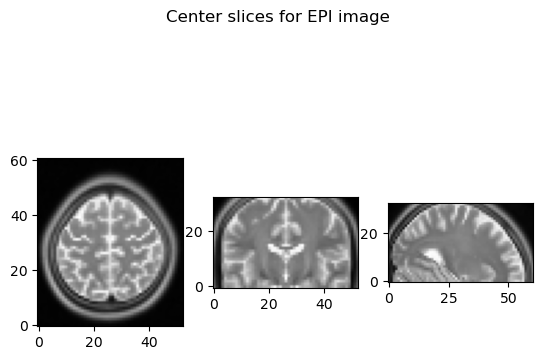

In [16]:
import matplotlib.pyplot as plt

def show_slices(slices):

   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))

   for i, slice in enumerate(slices):

       axes[i].imshow(slice, cmap="gray", origin="lower")


slice_0 = epi_img_data_final[26, :, :]
slice_1 = epi_img_data_final[:, 30, :]
slice_2 = epi_img_data_final[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

## FILTERS DEFINITION

Here we defines our sample filter masks.

In [17]:
#This is an identity filter: the resulting
filter1=np.zeros((3,3,3),dtype=np.float32)
filter1[1,1,1] =1.0

In [18]:
#This is an edge detector filter in xy axis filter: the resulting
filter2=np.zeros((3,3,3),dtype=np.float32)
filter2[0,0,1] = -0.25
filter2[2,0,1] = -0.25
filter2[0,2,1] = 0.25
filter2[2,2,1] = 0.25

In [19]:
#This is an edge detector filter in xz axis: the resulting
filter3=np.zeros((3,3,3),dtype=np.float32)
filter3[0,1,0] = -0.25
filter3[2,1,0] = -0.25
filter3[0,1,2] = 0.25
filter3[2,1,2] = 0.25

# YOUR CODE

### Extra Function we might need

In [20]:
def to_numpyarray(mp_arr, dtype=np.float32):
    return np.frombuffer(mp_arr.get_obj(), dtype=dtype)

def init_sharedarray(output_shared_array, img_shape, input_shared_array, padded_img_shape, kernel):
    global filtered_shared_space
    global filtered_shared_matrix

    filtered_shared_space = output_shared_array
    filtered_shared_matrix = to_numpyarray(filtered_shared_space).reshape(img_shape)

    global padded_shared_space
    global padded_shared_matrix
    padded_shared_space = input_shared_array
    padded_shared_matrix = to_numpyarray(padded_shared_space).reshape(padded_img_shape)

    global kernel_matrix
    kernel_matrix = kernel
    return

def same_padding(pad, arr):
    (rows, cols, depths) = arr.shape

    new_rows = rows + 2*pad
    new_cols = cols + 2*pad
    new_depths = depths + 2*pad

    padded = np.zeros((new_rows, new_cols, new_depths), dtype=arr.dtype)
    
    padded[pad:pad+rows, pad:pad+cols, pad:pad+depths] = arr

    for i in range(pad):
        # Pad along rows
        padded[i, pad:pad+cols, pad:pad+depths] = arr[0, :, :]
        padded[new_rows - i - 1, pad:pad+cols, pad:pad+depths] = arr[rows - 1, :, :]

        # Pad along columns
        padded[:, i, pad:pad+depths] = padded[:, pad, pad:pad+depths]
        padded[:, new_cols - i - 1, pad:pad+depths] = padded[:, new_cols - pad - 1, pad:pad+depths]

        # Pad along depths
        padded[:, :, i] = padded[:, :, pad]
        padded[:, :, new_depths - i - 1] = padded[:, :, new_depths - pad - 1]

    return padded

## SETUP EXPERIMENT

SET THE IMAGE RANGE AND THE FILTER

In [21]:
image = epi_img_data_final[:,:,:]  # Use the entire image
filter = filter1

Allocates the target image memory.

In [22]:
padded_image_arr = same_padding(filter.shape[0]//2, image)

image_shape = image.shape
print(f"Image shape: {image_shape}")
data_size = image_shape[0]*image_shape[1]*image_shape[2]

# Allocate shared memory for filtered image
filtered_image_shm = Array(ctypes.c_float, data_size, lock=True)

padded_shape = padded_image_arr.shape
print(f"Padded shape: {padded_shape}")
padded_data_size = padded_shape[0]*padded_shape[1]*padded_shape[2]

# Allocate shared memory for padded image
padded_image_shm = Array(ctypes.c_float, padded_data_size, lock=True)

Image shape: (33, 61, 53)
Padded shape: (35, 63, 55)


In [23]:
def same_padding(pad,arr):
    (rows,cols,depths)=arr.shape

    new_rows=rows+2*pad
    new_cols=cols+2*pad
    new_depths=depths+2*pad

    padded = np.zeros((new_rows,new_cols,new_depths), dtype=arr.dtype)
    
    padded[pad:pad+rows, pad:pad+cols, pad:pad+depths] = arr

    for i in range(pad):
        # Pad along rows
        padded[i, pad:pad+cols, pad:pad+depths] = arr[0, :, :]
        padded[new_rows - i - 1, pad:pad+cols, pad:pad+depths] = arr[rows - 1, :, :]

        # Pad along columns
        padded[:, i, pad:pad+depths] = padded[:, pad, pad:pad+depths]
        padded[:, new_cols - i - 1, pad:pad+depths] = padded[:, new_cols - pad - 1, pad:pad+depths]

        # Pad along depths
        padded[:, :, i] = padded[:, :, pad]
        padded[:, :, new_depths - i - 1] = padded[:, :, new_depths - pad - 1]

    return padded

In [24]:
def convolve(row):
    global filtered_shared_space
    global filtered_shared_matrix
    global padded_shared_space
    global padded_shared_matrix
    global kernel_matrix

    rows, cols, depths = filtered_shared_matrix.shape
    k = kernel_matrix.shape[0] // 2

    filtered_row = np.zeros((cols, depths), dtype=np.float32)
    
    for c in range(cols):
        for d in range(depths):
            padded_row = row + k
            padded_c = c + k
            padded_d = d + k
            
            roi = padded_shared_matrix[padded_row - k:padded_row + k + 1, 
                         padded_c - k:padded_c + k + 1, 
                         padded_d - k:padded_d + k + 1]
            
            filtered_row[c, d] = float(np.sum(roi * kernel_matrix))
    
    with filtered_shared_space.get_lock():
        filtered_shared_matrix[row, :, :] = filtered_row
    
    return

In [25]:
def run_parallel(output_shm, input_image, input_shm, padded_shape, filter_kernel, NUMCORES=4):
    image_shape = input_image.shape
    
    # Pad the input image
    padded_image_arr = same_padding(filter_kernel.shape[0]//2, input_image)
    
    # Get reference to padded shared memory and fill it
    padded_image = to_numpyarray(input_shm).reshape(padded_shape)
    padded_image[:] = padded_image_arr[:]
    
    rows = range(image_shape[0])

    # If NUMCORES is 1, run sequentially without creating a process pool
    if NUMCORES == 1:
        # Initialize shared arrays in main process
        init_sharedarray(output_shm, image_shape, input_shm, padded_shape, filter_kernel)
        
        # Run convolution sequentially
        for row in rows:
            convolve(row)
    else:
        # Use multiprocessing for NUMCORES > 1
        with mp.Pool(processes=NUMCORES,
                    initializer=init_sharedarray,
                    initargs=[output_shm, image_shape, input_shm, padded_shape, filter_kernel]) as p:
            p.map(convolve, rows)

    # Get result from shared memory
    result_matrix = to_numpyarray(output_shm).reshape(image_shape)
    return result_matrix

## OUTPUT OF CONVOLUTION
We will perform 2 tests, one in comparison to original image and another to a `scipy` function. We expect the tests to ouput the following:
* kernel1: `True`,`True`
* kernel2: `False`,`True`
* kernel3: `False`,`True`

In [53]:
filter=filter2

In [54]:

print("Starting parallel execution...")
start_time = time.time()

# Run with filter1 (identity filter)
result = run_parallel(filtered_image_shm, image, padded_image_shm, padded_shape, filter, NUMCORES=1)

end_time = time.time()

print(f"Parallel execution complete in {end_time - start_time:.2f}s!")
print(f"Result shape: {result.shape}")
print(f"Matches original image: {np.allclose(result, image, atol=1e-6)}")

Starting parallel execution...
Parallel execution complete in 0.42s!
Result shape: (33, 61, 53)
Matches original image: False


In [55]:
import scipy as sp

# Test with scipy
actual_output = sp.ndimage.correlate(image, filter, mode='nearest')
print(f"Matches scipy output: {np.allclose(result, actual_output, atol=1e-4)}")

# Get filtered image from shared memory for visualization
filtered_image = to_numpyarray(filtered_image_shm).reshape(image_shape)

Matches scipy output: True


# Show results


Text(0.5, 0.98, 'Center slices for EPI image')

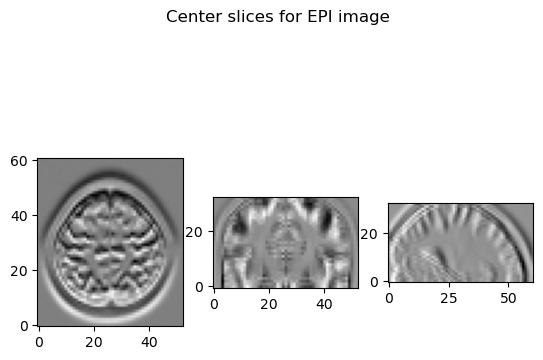

In [56]:
slice_0 = filtered_image[26, :, :]
slice_1 = filtered_image[:, 30, :]
slice_2 = filtered_image[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

In [29]:
slicetest_0 = test_convolved[26, :, :]
slicetest_1 = test_convolved[:, 30, :]
slicetest_2 = test_convolved[:, :, 16]

show_slices([slicetest_0, slicetest_1, slicetest_2])
plt.suptitle("Center slices for EPI image (test)")

NameError: name 'test_convolved' is not defined

In [ ]:
# print("Best execution time: {}".format(statistics.best))
# print("Worst execution time: {}".format(statistics.worst))
# print("Mean execution time: {mean} ({stdev} std dev)".format(mean=statistics.average,stdev=statistics.stdev))

# CONCLUSIONS